# ARC-AGI Dataset Statistics

This notebook provides comprehensive statistics and visualizations for the preprocessed ARC-AGI dataset.

**Features:**
- Configurable data path (works for ARC-AGI-1, ARC-AGI-2, etc.)
- Dataset overview statistics
- Distribution visualizations
- Train/test split comparison
- Augmentation analysis

## Configuration

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import pandas as pd

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuration
DATA_PATH = '../data/arc1concept-encoder-aug-1000'  # Change this for different datasets
DATASET_NAME = 'ARC-AGI-1'  # Change this for display purposes

print(f"Dataset: {DATASET_NAME}")
print(f"Data path: {DATA_PATH}")

Dataset: ARC-AGI-1
Data path: ../data/arc1concept-encoder-aug-1000


## 1. Load Dataset Metadata

In [2]:
def load_split_data(data_path, split):
    """Load data arrays for a specific split using memory mapping."""
    split_path = Path(data_path) / split
    
    data = {
        'inputs': np.load(split_path / 'all__inputs.npy', mmap_mode='r'),
        'labels': np.load(split_path / 'all__labels.npy', mmap_mode='r'),
        'puzzle_ids': np.load(split_path / 'all__puzzle_identifiers.npy'),
        'puzzle_indices': np.load(split_path / 'all__puzzle_indices.npy'),
        'group_indices': np.load(split_path / 'all__group_indices.npy'),
        'num_demos': np.load(split_path / 'all__num_demos.npy'),
    }
    
    with open(split_path / 'dataset.json') as f:
        data['metadata'] = json.load(f)
    
    return data

# Load both splits
train_data = load_split_data(DATA_PATH, 'train')
test_data = load_split_data(DATA_PATH, 'test')

# Load identifiers
with open(Path(DATA_PATH) / 'identifiers.json') as f:
    identifiers = json.load(f)

# Load original test puzzles
with open(Path(DATA_PATH) / 'test_puzzles.json') as f:
    test_puzzles = json.load(f)

print("✓ Data loaded successfully")

✓ Data loaded successfully


## 2. Overall Dataset Statistics

In [3]:
def compute_statistics(data):
    """Compute statistics for a split."""
    stats = {
        'num_examples': len(data['inputs']),
        'num_puzzles': len(data['puzzle_ids']),
        'num_groups': len(data['group_indices']) - 1,
        'examples_per_puzzle': np.diff(data['puzzle_indices']),
        'puzzles_per_group': np.diff(data['group_indices']),
        'demos_per_puzzle': data['num_demos'],
    }
    return stats

train_stats = compute_statistics(train_data)
test_stats = compute_statistics(test_data)

# Count base puzzles
base_puzzles = set()
for identifier in identifiers:
    if identifier != '<blank>':
        base = identifier.split('|||')[0]
        base_puzzles.add(base)

# Create summary table
summary_data = {
    'Metric': [
        'Base puzzles (groups)',
        'Augmented puzzles',
        'Total examples',
        'Avg. augmentations per group',
        'Avg. examples per puzzle',
        'Avg. demos per puzzle',
    ],
    'Train': [
        f"{train_stats['num_groups']:,}",
        f"{train_stats['num_puzzles']:,}",
        f"{train_stats['num_examples']:,}",
        f"{train_stats['puzzles_per_group'].mean():.0f}",
        f"{train_stats['examples_per_puzzle'].mean():.2f}",
        f"{train_stats['demos_per_puzzle'].mean():.2f}",
    ],
    'Test': [
        f"{test_stats['num_groups']:,}",
        f"{test_stats['num_puzzles']:,}",
        f"{test_stats['num_examples']:,}",
        f"{test_stats['puzzles_per_group'].mean():.0f}",
        f"{test_stats['examples_per_puzzle'].mean():.2f}",
        f"{test_stats['demos_per_puzzle'].mean():.2f}",
    ],
    'Total': [
        f"{len(base_puzzles):,}",
        f"{train_stats['num_puzzles'] + test_stats['num_puzzles']:,}",
        f"{train_stats['num_examples'] + test_stats['num_examples']:,}",
        f"{(train_stats['puzzles_per_group'].mean() + test_stats['puzzles_per_group'].mean()) / 2:.0f}",
        f"{(train_stats['examples_per_puzzle'].mean() + test_stats['examples_per_puzzle'].mean()) / 2:.2f}",
        f"{(train_stats['demos_per_puzzle'].mean() + test_stats['demos_per_puzzle'].mean()) / 2:.2f}",
    ]
}

df_summary = pd.DataFrame(summary_data)
print(f"\n{'='*60}")
print(f"  {DATASET_NAME} Dataset Summary")
print(f"{'='*60}\n")
print(df_summary.to_string(index=False))
print(f"\n{'='*60}")


  ARC-AGI-1 Dataset Summary

                      Metric     Train      Test     Total
       Base puzzles (groups)       560       400       960
           Augmented puzzles   508,544   368,149   876,693
              Total examples 2,373,921 1,646,169 4,020,090
Avg. augmentations per group       908       920       914
    Avg. examples per puzzle      4.67      4.47      4.57
       Avg. demos per puzzle      3.07      3.42      3.25



## 3. Distribution Visualizations

### 3.1 Examples per Puzzle Distribution

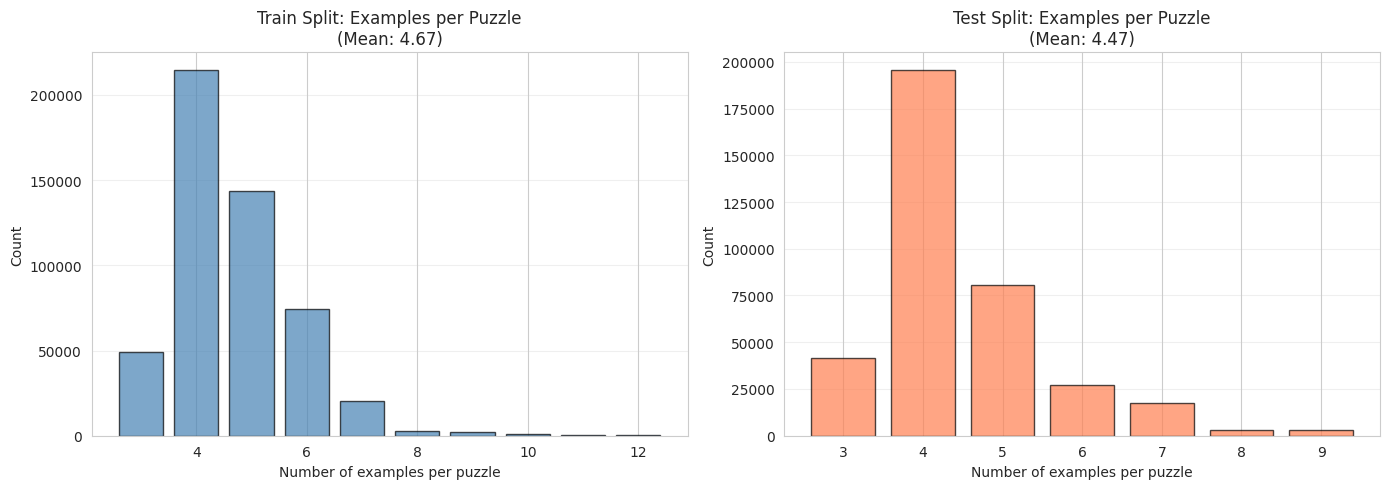


Examples per Puzzle Statistics:
  Train: min=3, max=12, mean=4.67, std=1.12
  Test:  min=3, max=9, mean=4.47, std=1.08


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
ax = axes[0]
train_counts = Counter(train_stats['examples_per_puzzle'])
ax.bar(train_counts.keys(), train_counts.values(), color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of examples per puzzle')
ax.set_ylabel('Count')
ax.set_title(f'Train Split: Examples per Puzzle\n(Mean: {train_stats["examples_per_puzzle"].mean():.2f})')
ax.grid(axis='y', alpha=0.3)

# Test distribution
ax = axes[1]
test_counts = Counter(test_stats['examples_per_puzzle'])
ax.bar(test_counts.keys(), test_counts.values(), color='coral', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of examples per puzzle')
ax.set_ylabel('Count')
ax.set_title(f'Test Split: Examples per Puzzle\n(Mean: {test_stats["examples_per_puzzle"].mean():.2f})')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nExamples per Puzzle Statistics:")
print(f"  Train: min={train_stats['examples_per_puzzle'].min()}, "
      f"max={train_stats['examples_per_puzzle'].max()}, "
      f"mean={train_stats['examples_per_puzzle'].mean():.2f}, "
      f"std={train_stats['examples_per_puzzle'].std():.2f}")
print(f"  Test:  min={test_stats['examples_per_puzzle'].min()}, "
      f"max={test_stats['examples_per_puzzle'].max()}, "
      f"mean={test_stats['examples_per_puzzle'].mean():.2f}, "
      f"std={test_stats['examples_per_puzzle'].std():.2f}")

### 3.2 Demonstrations per Puzzle Distribution

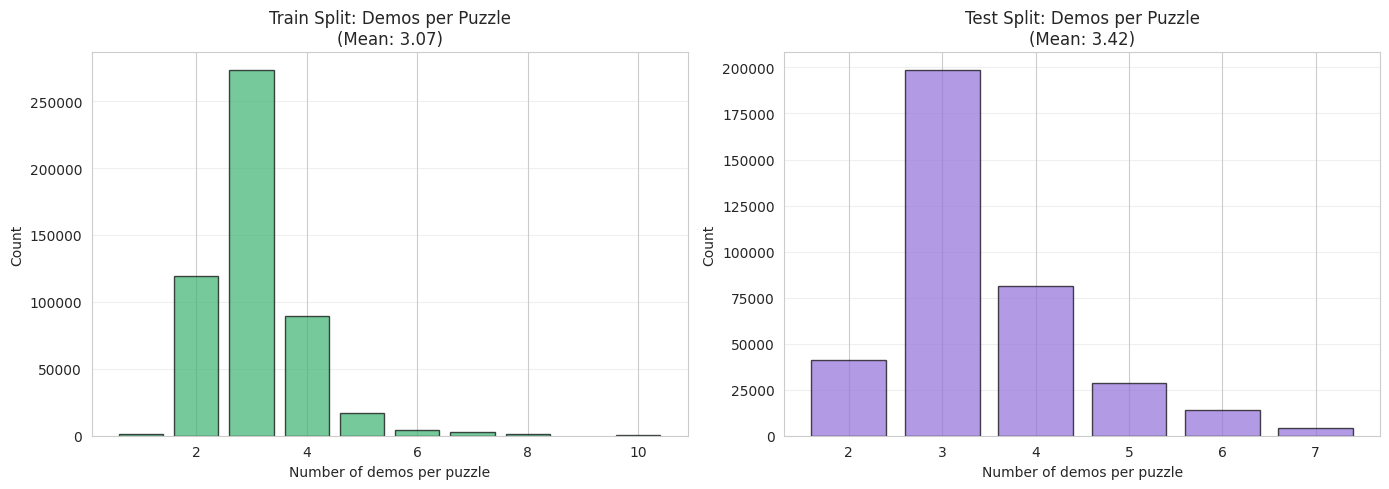


Demos per Puzzle Statistics:
  Train: min=1, max=10, mean=3.07, std=0.90
  Test:  min=2, max=7, mean=3.42, std=0.99


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
ax = axes[0]
train_demo_counts = Counter(train_stats['demos_per_puzzle'])
ax.bar(train_demo_counts.keys(), train_demo_counts.values(), color='mediumseagreen', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of demos per puzzle')
ax.set_ylabel('Count')
ax.set_title(f'Train Split: Demos per Puzzle\n(Mean: {train_stats["demos_per_puzzle"].mean():.2f})')
ax.grid(axis='y', alpha=0.3)

# Test distribution
ax = axes[1]
test_demo_counts = Counter(test_stats['demos_per_puzzle'])
ax.bar(test_demo_counts.keys(), test_demo_counts.values(), color='mediumpurple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of demos per puzzle')
ax.set_ylabel('Count')
ax.set_title(f'Test Split: Demos per Puzzle\n(Mean: {test_stats["demos_per_puzzle"].mean():.2f})')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDemos per Puzzle Statistics:")
print(f"  Train: min={train_stats['demos_per_puzzle'].min()}, "
      f"max={train_stats['demos_per_puzzle'].max()}, "
      f"mean={train_stats['demos_per_puzzle'].mean():.2f}, "
      f"std={train_stats['demos_per_puzzle'].std():.2f}")
print(f"  Test:  min={test_stats['demos_per_puzzle'].min()}, "
      f"max={test_stats['demos_per_puzzle'].max()}, "
      f"mean={test_stats['demos_per_puzzle'].mean():.2f}, "
      f"std={test_stats['demos_per_puzzle'].std():.2f}")

### 3.3 Augmentations per Group Distribution

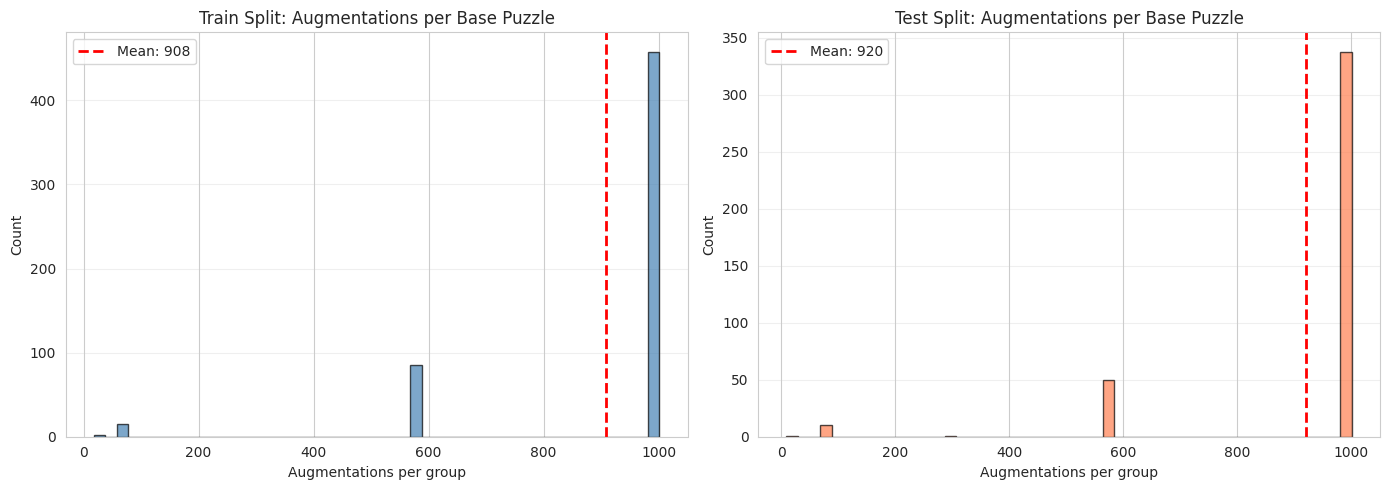


Augmentations per Group Statistics:
  Train: min=18, max=1001, mean=908, std=212.85
  Test:  min=9, max=1001, mean=920, std=203.46

  Note: Target is 1000 augmentations per group. Lower values indicate
        fewer unique augmentations possible due to puzzle structure.


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
ax = axes[0]
ax.hist(train_stats['puzzles_per_group'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(train_stats['puzzles_per_group'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {train_stats['puzzles_per_group'].mean():.0f}")
ax.set_xlabel('Augmentations per group')
ax.set_ylabel('Count')
ax.set_title(f'Train Split: Augmentations per Base Puzzle')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Test distribution
ax = axes[1]
ax.hist(test_stats['puzzles_per_group'], bins=50, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(test_stats['puzzles_per_group'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {test_stats['puzzles_per_group'].mean():.0f}")
ax.set_xlabel('Augmentations per group')
ax.set_ylabel('Count')
ax.set_title(f'Test Split: Augmentations per Base Puzzle')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nAugmentations per Group Statistics:")
print(f"  Train: min={train_stats['puzzles_per_group'].min()}, "
      f"max={train_stats['puzzles_per_group'].max()}, "
      f"mean={train_stats['puzzles_per_group'].mean():.0f}, "
      f"std={train_stats['puzzles_per_group'].std():.2f}")
print(f"  Test:  min={test_stats['puzzles_per_group'].min()}, "
      f"max={test_stats['puzzles_per_group'].max()}, "
      f"mean={test_stats['puzzles_per_group'].mean():.0f}, "
      f"std={test_stats['puzzles_per_group'].std():.2f}")
print(f"\n  Note: Target is 1000 augmentations per group. Lower values indicate")
print(f"        fewer unique augmentations possible due to puzzle structure.")

## 4. Original Test Puzzles Analysis

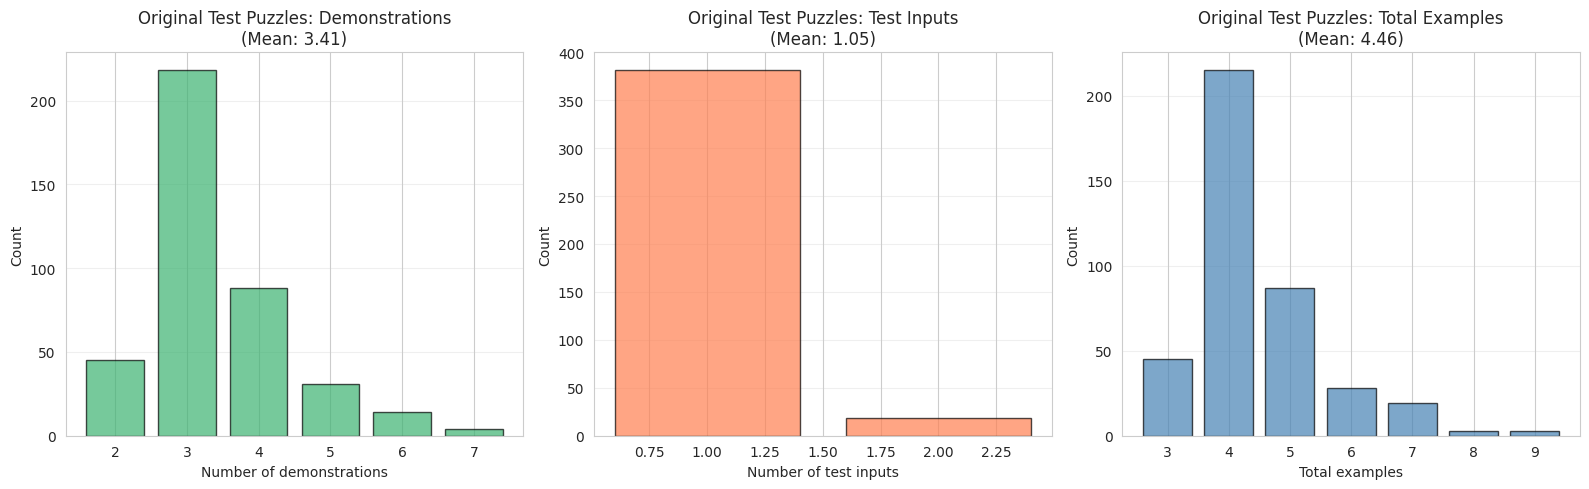


Original Test Puzzles (n=400):
  Demonstrations: min=2, max=7, mean=3.41
  Test inputs:    min=1, max=2, mean=1.05
  Total examples: min=3, max=9, mean=4.46


In [7]:
# Analyze original test puzzles
train_examples = []
test_examples = []
total_examples = []

for puzzle_id, puzzle in test_puzzles.items():
    n_train = len(puzzle.get('train', []))
    n_test = len(puzzle.get('test', []))
    train_examples.append(n_train)
    test_examples.append(n_test)
    total_examples.append(n_train + n_test)

train_examples = np.array(train_examples)
test_examples = np.array(test_examples)
total_examples = np.array(total_examples)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Demos distribution
ax = axes[0]
demo_counts = Counter(train_examples)
ax.bar(demo_counts.keys(), demo_counts.values(), color='mediumseagreen', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of demonstrations')
ax.set_ylabel('Count')
ax.set_title(f'Original Test Puzzles: Demonstrations\n(Mean: {train_examples.mean():.2f})')
ax.grid(axis='y', alpha=0.3)

# Test examples distribution
ax = axes[1]
test_counts = Counter(test_examples)
ax.bar(test_counts.keys(), test_counts.values(), color='coral', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of test inputs')
ax.set_ylabel('Count')
ax.set_title(f'Original Test Puzzles: Test Inputs\n(Mean: {test_examples.mean():.2f})')
ax.grid(axis='y', alpha=0.3)

# Total examples distribution
ax = axes[2]
total_counts = Counter(total_examples)
ax.bar(total_counts.keys(), total_counts.values(), color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Total examples')
ax.set_ylabel('Count')
ax.set_title(f'Original Test Puzzles: Total Examples\n(Mean: {total_examples.mean():.2f})')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nOriginal Test Puzzles (n={len(test_puzzles)}):")
print(f"  Demonstrations: min={train_examples.min()}, max={train_examples.max()}, mean={train_examples.mean():.2f}")
print(f"  Test inputs:    min={test_examples.min()}, max={test_examples.max()}, mean={test_examples.mean():.2f}")
print(f"  Total examples: min={total_examples.min()}, max={total_examples.max()}, mean={total_examples.mean():.2f}")

## 5. Train/Test Split Comparison

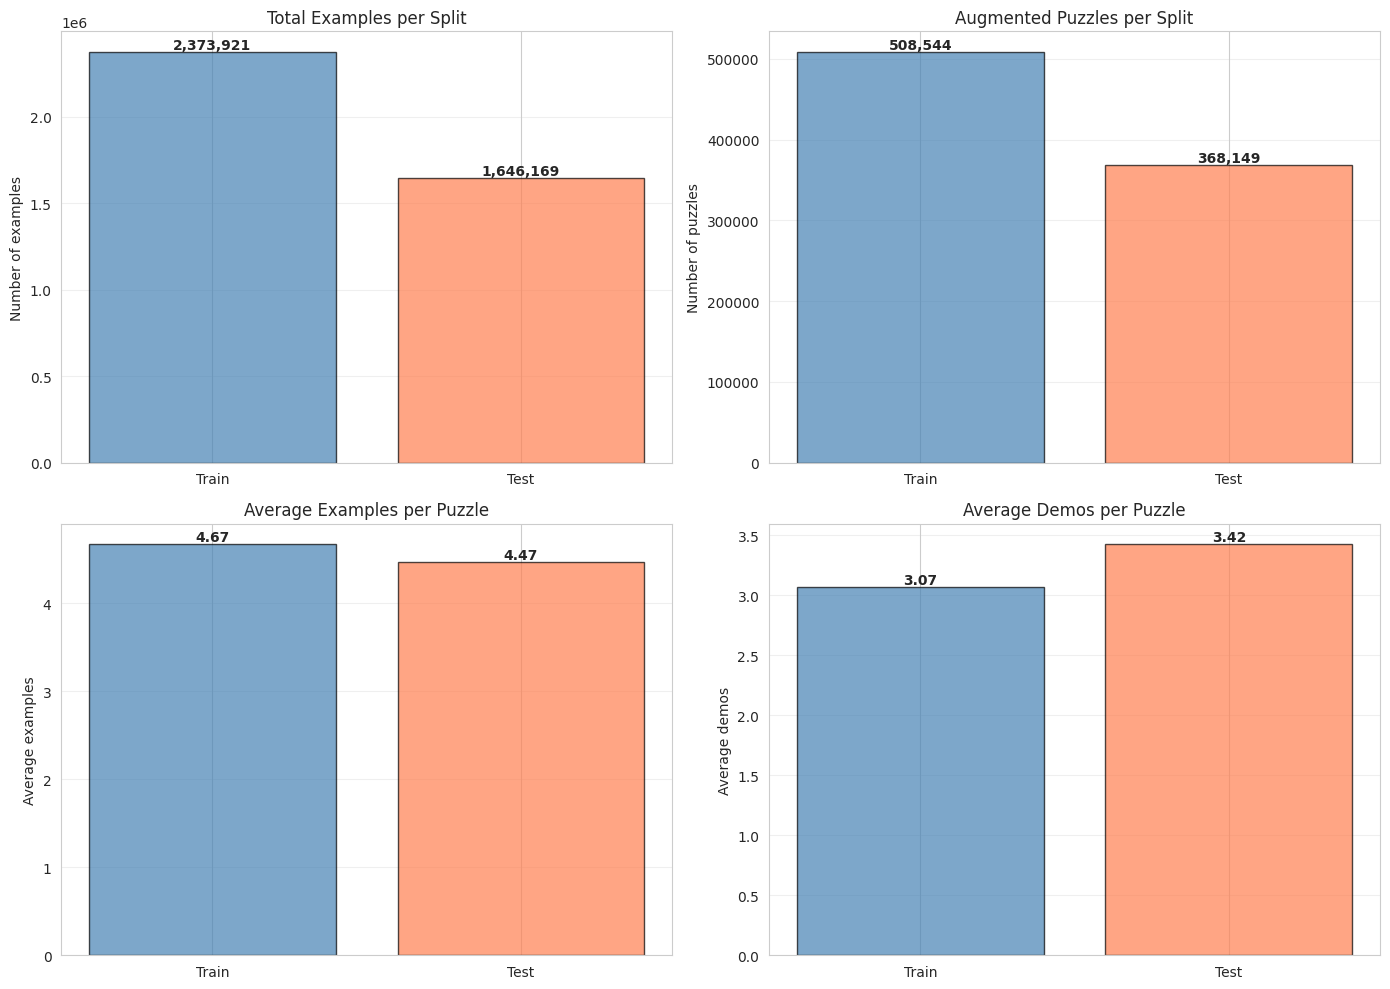

In [8]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Split sizes
ax = axes[0, 0]
splits = ['Train', 'Test']
examples = [train_stats['num_examples'], test_stats['num_examples']]
colors = ['steelblue', 'coral']
bars = ax.bar(splits, examples, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of examples')
ax.set_title('Total Examples per Split')
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, examples):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Puzzles per split
ax = axes[0, 1]
puzzles = [train_stats['num_puzzles'], test_stats['num_puzzles']]
bars = ax.bar(splits, puzzles, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of puzzles')
ax.set_title('Augmented Puzzles per Split')
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, puzzles):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Average examples per puzzle
ax = axes[1, 0]
avg_examples = [train_stats['examples_per_puzzle'].mean(), test_stats['examples_per_puzzle'].mean()]
bars = ax.bar(splits, avg_examples, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Average examples')
ax.set_title('Average Examples per Puzzle')
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, avg_examples):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Average demos per puzzle
ax = axes[1, 1]
avg_demos = [train_stats['demos_per_puzzle'].mean(), test_stats['demos_per_puzzle'].mean()]
bars = ax.bar(splits, avg_demos, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Average demos')
ax.set_title('Average Demos per Puzzle')
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, avg_demos):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Identifier Analysis

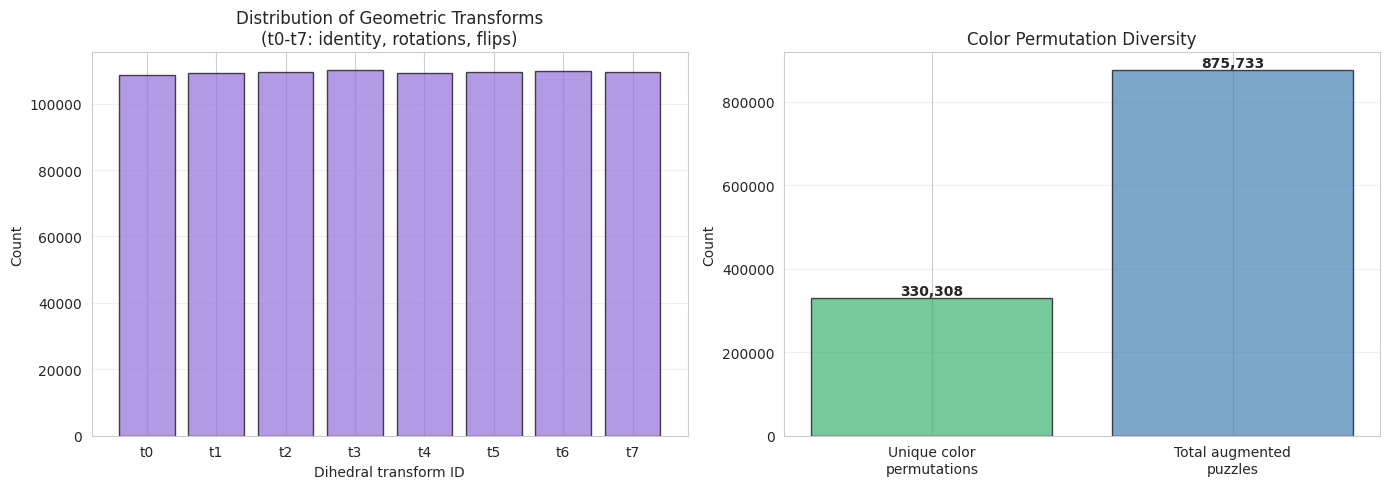


Augmentation Structure:
  Base puzzles: 960
  Augmented puzzles: 876693  (excluding <blank>)
  Unique color permutations: 330,308
  Geometric transforms: 8 types (t0-t7)
  Average augmentations per base: 913


In [9]:
# Parse identifiers to understand augmentation structure
base_ids = set()
transform_ids = []
color_perms = []

for identifier in identifiers:
    if identifier != '<blank>':
        parts = identifier.split('|||')
        base_ids.add(parts[0])
        if len(parts) > 1:
            transform_ids.append(parts[1])
        if len(parts) > 2:
            color_perms.append(parts[2])

# Count transform types
transform_counts = Counter(transform_ids)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Transform distribution
ax = axes[0]
transforms = sorted(transform_counts.keys())
counts = [transform_counts[t] for t in transforms]
ax.bar(transforms, counts, color='mediumpurple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Dihedral transform ID')
ax.set_ylabel('Count')
ax.set_title('Distribution of Geometric Transforms\n(t0-t7: identity, rotations, flips)')
ax.grid(axis='y', alpha=0.3)

# Color permutation uniqueness
ax = axes[1]
unique_color_perms = len(set(color_perms))
total_augmented = len(color_perms)
data = [
    ('Unique color\npermutations', unique_color_perms),
    ('Total augmented\npuzzles', total_augmented)
]
labels = [d[0] for d in data]
values = [d[1] for d in data]
bars = ax.bar(labels, values, color=['mediumseagreen', 'steelblue'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Count')
ax.set_title('Color Permutation Diversity')
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nAugmentation Structure:")
print(f"  Base puzzles: {len(base_ids)}")
print(f"  Augmented puzzles: {len(identifiers) - 1}  (excluding <blank>)")
print(f"  Unique color permutations: {unique_color_perms:,}")
print(f"  Geometric transforms: {len(transform_counts)} types (t0-t7)")
print(f"  Average augmentations per base: {(len(identifiers) - 1) / len(base_ids):.0f}")

## 7. Data Efficiency Analysis

In [10]:
# Calculate augmentation factor
train_base = train_stats['num_groups']
test_base = test_stats['num_groups']
total_base = train_base + test_base

train_aug_factor = train_stats['num_puzzles'] / train_base
test_aug_factor = test_stats['num_puzzles'] / test_base

# Create summary
efficiency_data = {
    'Metric': [
        'Base puzzles',
        'Augmented puzzles',
        'Augmentation factor',
        'Base examples (estimated)',
        'Augmented examples',
        'Data expansion'
    ],
    'Train': [
        f"{train_base}",
        f"{train_stats['num_puzzles']:,}",
        f"{train_aug_factor:.0f}×",
        f"{train_base * 4:.0f}",  # Assuming ~4 examples per base puzzle
        f"{train_stats['num_examples']:,}",
        f"{train_stats['num_examples'] / (train_base * 4):.0f}×"
    ],
    'Test': [
        f"{test_base}",
        f"{test_stats['num_puzzles']:,}",
        f"{test_aug_factor:.0f}×",
        f"{test_base * 4:.0f}",
        f"{test_stats['num_examples']:,}",
        f"{test_stats['num_examples'] / (test_base * 4):.0f}×"
    ]
}

df_efficiency = pd.DataFrame(efficiency_data)
print("\n" + "="*60)
print("  Data Efficiency Through Augmentation")
print("="*60 + "\n")
print(df_efficiency.to_string(index=False))
print("\n" + "="*60)
print("\nKey Insights:")
print(f"  • Each base puzzle generates ~{train_aug_factor:.0f} augmented versions")
print(f"  • Total data expansion: ~{train_stats['num_examples'] / (total_base * 4):.0f}× from base examples")
print(f"  • This enables training with sufficient data despite only {total_base} base puzzles")


  Data Efficiency Through Augmentation

                   Metric     Train      Test
             Base puzzles       560       400
        Augmented puzzles   508,544   368,149
      Augmentation factor      908×      920×
Base examples (estimated)      2240      1600
       Augmented examples 2,373,921 1,646,169
           Data expansion     1060×     1029×


Key Insights:
  • Each base puzzle generates ~908 augmented versions
  • Total data expansion: ~618× from base examples
  • This enables training with sufficient data despite only 960 base puzzles


## 8. Export Summary Report

In [11]:
# Create a comprehensive summary report
report = f"""
{'='*70}
{DATASET_NAME} Dataset Statistics Report
{'='*70}

Data Path: {DATA_PATH}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*70}
1. OVERALL SUMMARY
{'='*70}

Base puzzles:              {len(base_puzzles):,}
  - Training groups:       {train_stats['num_groups']:,}
  - Test groups:           {test_stats['num_groups']:,}

Augmented puzzles:         {train_stats['num_puzzles'] + test_stats['num_puzzles']:,}
  - Training:              {train_stats['num_puzzles']:,}
  - Test:                  {test_stats['num_puzzles']:,}

Total examples:            {train_stats['num_examples'] + test_stats['num_examples']:,}
  - Training:              {train_stats['num_examples']:,}
  - Test:                  {test_stats['num_examples']:,}

Augmentation factor:       ~{(train_stats['num_puzzles'] + test_stats['num_puzzles']) / len(base_puzzles):.0f}×

{'='*70}
2. TRAIN SPLIT DETAILS
{'='*70}

Puzzles:
  - Total augmented:       {train_stats['num_puzzles']:,}
  - Per group (avg):       {train_stats['puzzles_per_group'].mean():.0f}
  - Per group (range):     {train_stats['puzzles_per_group'].min()}-{train_stats['puzzles_per_group'].max()}

Examples:
  - Total:                 {train_stats['num_examples']:,}
  - Per puzzle (avg):      {train_stats['examples_per_puzzle'].mean():.2f}
  - Per puzzle (range):    {train_stats['examples_per_puzzle'].min()}-{train_stats['examples_per_puzzle'].max()}

Demonstrations:
  - Per puzzle (avg):      {train_stats['demos_per_puzzle'].mean():.2f}
  - Per puzzle (range):    {train_stats['demos_per_puzzle'].min()}-{train_stats['demos_per_puzzle'].max()}

{'='*70}
3. TEST SPLIT DETAILS
{'='*70}

Puzzles:
  - Total augmented:       {test_stats['num_puzzles']:,}
  - Per group (avg):       {test_stats['puzzles_per_group'].mean():.0f}
  - Per group (range):     {test_stats['puzzles_per_group'].min()}-{test_stats['puzzles_per_group'].max()}

Examples:
  - Total:                 {test_stats['num_examples']:,}
  - Per puzzle (avg):      {test_stats['examples_per_puzzle'].mean():.2f}
  - Per puzzle (range):    {test_stats['examples_per_puzzle'].min()}-{test_stats['examples_per_puzzle'].max()}

Demonstrations:
  - Per puzzle (avg):      {test_stats['demos_per_puzzle'].mean():.2f}
  - Per puzzle (range):    {test_stats['demos_per_puzzle'].min()}-{test_stats['demos_per_puzzle'].max()}

{'='*70}
4. ORIGINAL TEST PUZZLES (PRE-AUGMENTATION)
{'='*70}

Total original puzzles:    {len(test_puzzles)}

Demonstrations:
  - Per puzzle (avg):      {train_examples.mean():.2f}
  - Per puzzle (range):    {train_examples.min()}-{train_examples.max()}

Test inputs:
  - Per puzzle (avg):      {test_examples.mean():.2f}
  - Per puzzle (range):    {test_examples.min()}-{test_examples.max()}

Total examples:
  - Per puzzle (avg):      {total_examples.mean():.2f}
  - Per puzzle (range):    {total_examples.min()}-{total_examples.max()}

{'='*70}
5. AUGMENTATION STRUCTURE
{'='*70}

Unique color permutations: {unique_color_perms:,}
Geometric transforms:      {len(transform_counts)} types (t0-t7: dihedral group D₄)
Total unique puzzles:      {len(identifiers) - 1:,} (excluding <blank>)

Transform distribution:    {dict(transform_counts)}

{'='*70}
6. DATA FORMAT
{'='*70}

Vocabulary size:           {train_data['metadata']['vocab_size']}
Sequence length:           {train_data['metadata']['seq_len']} (30×30 grid)
Padding ID:                {train_data['metadata']['pad_id']}
Token encoding:            0=PAD, 1=EOS, 2-11=colors 0-9

{'='*70}
"""

print(report)

# Optionally save to file
output_file = Path(DATA_PATH) / 'dataset_statistics.txt'
with open(output_file, 'w') as f:
    f.write(report)
print(f"\n✓ Report saved to: {output_file}")


ARC-AGI-1 Dataset Statistics Report

Data Path: ../data/arc1concept-encoder-aug-1000
Generated: 2026-01-14 12:12:58

1. OVERALL SUMMARY

Base puzzles:              960
  - Training groups:       560
  - Test groups:           400

Augmented puzzles:         876,693
  - Training:              508,544
  - Test:                  368,149

Total examples:            4,020,090
  - Training:              2,373,921
  - Test:                  1,646,169

Augmentation factor:       ~913×

2. TRAIN SPLIT DETAILS

Puzzles:
  - Total augmented:       508,544
  - Per group (avg):       908
  - Per group (range):     18-1001

Examples:
  - Total:                 2,373,921
  - Per puzzle (avg):      4.67
  - Per puzzle (range):    3-12

Demonstrations:
  - Per puzzle (avg):      3.07
  - Per puzzle (range):    1-10

3. TEST SPLIT DETAILS

Puzzles:
  - Total augmented:       368,149
  - Per group (avg):       920
  - Per group (range):     9-1001

Examples:
  - Total:                 1,646,169
  - Per 

## Summary

This notebook provides a comprehensive analysis of the preprocessed ARC-AGI dataset, including:

1. **Overall statistics**: Base puzzles, augmented puzzles, total examples
2. **Distribution analysis**: Examples per puzzle, demos per puzzle, augmentations per group
3. **Split comparison**: Train vs test split characteristics
4. **Original data**: Pre-augmentation statistics
5. **Augmentation structure**: Color permutations and geometric transforms
6. **Data efficiency**: Expansion factor through augmentation

**To use with different datasets:**
1. Change `DATA_PATH` to point to your dataset directory
2. Update `DATASET_NAME` for display purposes
3. Run all cells

**Example for ARC-AGI-2:**
```python
DATA_PATH = '../data/arc2-encoder-aug-1000'
DATASET_NAME = 'ARC-AGI-2'
```